# Mesh Grid Initializer

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def initialize_rve_grid(grid_size, initial_value):
    """
    Initializes a 2D array to represent the RVE grid.
    
    Parameters:
        grid_size (tuple): Size of the grid as (rows, columns).
        initial_value (float): Initial value for each grid point.
        
    Returns:
        np.ndarray: Initialized 2D grid.
    """
    # Create a 2D array initialized with the specified large value
    grid = np.full(grid_size, initial_value, dtype=float)
    return grid

# Read Spline Coordinates

In [2]:
import pandas as pd
import random

def read_spline_coordinates(file_path, sheet_number=None):
    """
    Reads spline coordinates (x, y) from a specified or random sheet in an Excel file.
    
    Parameters:
        file_path (str): Path to the Excel file.
        sheet_number (int, optional): The sheet number to read coordinates from.
                                      If None, a random sheet will be chosen.
    
    Returns:
        pd.DataFrame: DataFrame containing spline coordinates with columns ['x', 'y'].
        str: The name of the sheet read.
    """
    # Load the Excel file
    excel_data = pd.ExcelFile(file_path)
    
    # If no sheet number is specified, select a random sheet
    if sheet_number is None:
        sheet_number = random.randint(0, len(excel_data.sheet_names) - 1)
    
    # Read the data from the specified sheet
    sheet_name = excel_data.sheet_names[sheet_number]
    data = pd.read_excel(excel_data, sheet_name=sheet_name, header=None, usecols=[0, 1], names=['x', 'y'])
    
    return data, sheet_name

# Maximum Radius 

In [3]:
import numpy as np

def compute_max_distance_from_centroid(spline_data):
    """
    Computes the maximum distance from the centroid to any point in the spline.
    Handles cases where the first and last coordinates are the same.
    
    Parameters:
        spline_data (pd.DataFrame): DataFrame containing spline coordinates ['x', 'y'].
    
    Returns:
        float: The maximum distance from the centroid to any spline point.
    """
    # Remove the last point if it's identical to the first (to avoid double-counting)
    if (spline_data.iloc[0]['x'] == spline_data.iloc[-1]['x'] and
        spline_data.iloc[0]['y'] == spline_data.iloc[-1]['y']):
        spline_data = spline_data.iloc[:-1]

    # Compute the centroid
    centroid_x = spline_data['x'].mean()
    centroid_y = spline_data['y'].mean()

    # Compute distances from the centroid to all points
    distances = np.sqrt((spline_data['x'] - centroid_x)**2 + (spline_data['y'] - centroid_y)**2)
    
    # Find and return the maximum distance
    return distances.max()

# Scale Spline Coordinates

In [4]:
import numpy as np
import random

def scale_spline(spline_data, scaling_factor=None, scaling_bounds=(0.5, 2.0)):
    """
    Scales a closed spline by a specified or random scaling factor, ensuring 
    the first and last point (identical) are not double-counted in centroid calculation.
    
    Parameters:
        spline_data (pd.DataFrame): DataFrame containing spline coordinates ['x', 'y'].
        scaling_factor (float, optional): The scaling factor to apply. If None, a random scaling factor
                                          between scaling_bounds will be generated.
        scaling_bounds (tuple): Bounds for the random scaling factor as (min, max).
    
    Returns:
        pd.DataFrame: Scaled spline coordinates stored in a new DataFrame ['x', 'y'].
    """
    # Exclude the last point if it's identical to the first (for closed spline)
    if (spline_data.iloc[0]['x'] == spline_data.iloc[-1]['x'] and 
        spline_data.iloc[0]['y'] == spline_data.iloc[-1]['y']):
        valid_data = spline_data.iloc[:-1]
    else:
        valid_data = spline_data
    
    # Compute the centroid
    centroid_x = valid_data['x'].mean()
    centroid_y = valid_data['y'].mean()
    
    # If no scaling factor is provided, generate a random one
    if scaling_factor is None:
        scaling_factor = random.uniform(scaling_bounds[0], scaling_bounds[1])
    
    print(f"Scaling factor: {scaling_factor}")
    
    # Compute the scaled coordinates
    scaled_spline_data = spline_data.copy()
    scaled_spline_data['x'] = centroid_x + (spline_data['x'] - centroid_x) * scaling_factor
    scaled_spline_data['y'] = centroid_y + (spline_data['y'] - centroid_y) * scaling_factor
    
    return scaled_spline_data

# Rotate Spline Coordinates

In [5]:
import numpy as np

def rotate_spline(scaled_spline_data, rotation_angle=None):
    """
    Rotates a spline around its centroid by a specified or random angle.
    
    Parameters:
        scaled_spline_data (pd.DataFrame): DataFrame containing spline coordinates ['x', 'y'].
        rotation_angle (float, optional): The rotation angle in degrees. If None, a random angle 
                                          between 0 and 360 degrees will be selected.
    
    Returns:
        pd.DataFrame: Rotated spline coordinates stored in a new DataFrame ['x', 'y'].
    """
    # Compute the centroid
    centroid_x = scaled_spline_data['x'].mean()
    centroid_y = scaled_spline_data['y'].mean()
    
    # If no rotation angle is provided, generate a random one
    if rotation_angle is None:
        rotation_angle = np.random.uniform(0, 360)
    
    print(f"Rotation angle: {rotation_angle} degrees")
    
    # Convert angle to radians for the rotation matrix
    angle_rad = np.radians(rotation_angle)
    
    # Create the rotation matrix
    rotation_matrix = np.array([
        [np.cos(angle_rad), -np.sin(angle_rad)],
        [np.sin(angle_rad), np.cos(angle_rad)]
    ])
    
    # Shift the points to origin (centroid at (0, 0))
    shifted_points = scaled_spline_data[['x', 'y']].to_numpy() - np.array([centroid_x, centroid_y])
    
    # Apply rotation
    rotated_points = shifted_points.dot(rotation_matrix.T)
    
    # Shift back to the original centroid
    rotated_points += np.array([centroid_x, centroid_y])
    
    # Create a new DataFrame for the rotated spline
    rotated_spline_data = scaled_spline_data.copy()
    rotated_spline_data['x'], rotated_spline_data['y'] = rotated_points[:, 0], rotated_points[:, 1]
    
    return rotated_spline_data

# Displace Spline Coordinates

In [6]:
import numpy as np

def displace_spline_uniformly(spline_data, grid_bounds, displacement=None):
    """
    Displaces the entire spline uniformly by either a specified or random displacement.
    
    Parameters:
        spline_data (pd.DataFrame): DataFrame containing spline coordinates ['x', 'y'].
        grid_bounds (tuple): Bounds of the grid as (grid_rows, grid_columns).
        displacement (tuple, optional): Manually specified displacement as (dx, dy). 
                                        If None, a random displacement is generated.
    
    Returns:
        pd.DataFrame: Displaced spline coordinates stored in a new DataFrame ['x', 'y'].
    """
    grid_rows, grid_columns = grid_bounds
    
    if displacement is None:
        # Generate a single random displacement for x and y
        dx = np.random.uniform(0, grid_columns)
        dy = np.random.uniform(0, grid_rows)
        print(f"Random Displacement (dx, dy): ({dx:.2f}, {dy:.2f})")
    else:
        # Use the manually specified displacement
        dx, dy = displacement
        print(f"Manual Displacement (dx, dy): ({dx:.2f}, {dy:.2f})")
    
    # Apply the uniform displacement to all points
    displaced_spline_data = spline_data.copy()
    displaced_spline_data['x'] += dx
    displaced_spline_data['y'] += dy
    
    return displaced_spline_data

# Periodic Boundary Application

In [7]:
def apply_periodic_boundary_disjoint(displaced_spline_data, grid_bounds, density=100):
    """
    Ensures periodic boundaries by checking and wrapping splines exceeding RVE edges.
    Returns a list of disjoint splines for periodic copies.
    
    Parameters:
        displaced_spline_data (pd.DataFrame): Spline points with columns ['x', 'y'].
        grid_bounds (tuple): Bounds of the grid as (grid_rows, grid_columns).
        density (int): Number of points to interpolate for densification.
    
    Returns:
        list of pd.DataFrame: List of DataFrames for the original and periodic splines.
    """
    grid_rows, grid_cols = grid_bounds
    
    # Extract x and y coordinates from the spline
    x = displaced_spline_data['x'].values
    y = displaced_spline_data['y'].values
    
    # Densify the spline using interpolation
    tck, u = splprep([x, y], s=0)
    u_fine = np.linspace(0, 1, density)
    x_densified, y_densified = splev(u_fine, tck)
    
    # Check which edges are exceeded
    exceeds_left = np.any(x_densified < 0)
    exceeds_right = np.any(x_densified >= grid_cols)
    exceeds_top = np.any(y_densified < 0)
    exceeds_bottom = np.any(y_densified >= grid_rows)
    
    # Initialize a list to hold all splines (original + wrapped)
    splines = []
    
    # Add the original spline
    splines.append(displaced_spline_data)
    
    # Create shifted splines based on boundary exceedance
    if exceeds_left:
        splines.append(displaced_spline_data.copy().assign(x=displaced_spline_data['x'] + grid_cols))
    if exceeds_right:
        splines.append(displaced_spline_data.copy().assign(x=displaced_spline_data['x'] - grid_cols))
    if exceeds_top:
        splines.append(displaced_spline_data.copy().assign(y=displaced_spline_data['y'] + grid_rows))
    if exceeds_bottom:
        splines.append(displaced_spline_data.copy().assign(y=displaced_spline_data['y'] - grid_rows))
    
    # Handle diagonal cases
    if exceeds_left and exceeds_top:
        splines.append(displaced_spline_data.copy().assign(x=displaced_spline_data['x'] + grid_cols,
                                                           y=displaced_spline_data['y'] + grid_rows))
    if exceeds_left and exceeds_bottom:
        splines.append(displaced_spline_data.copy().assign(x=displaced_spline_data['x'] + grid_cols,
                                                           y=displaced_spline_data['y'] - grid_rows))
    if exceeds_right and exceeds_top:
        splines.append(displaced_spline_data.copy().assign(x=displaced_spline_data['x'] - grid_cols,
                                                           y=displaced_spline_data['y'] + grid_rows))
    if exceeds_right and exceeds_bottom:
        splines.append(displaced_spline_data.copy().assign(x=displaced_spline_data['x'] - grid_cols,
                                                           y=displaced_spline_data['y'] - grid_rows))
    
    return splines

# Update Grid

In [8]:
def update_grid_with_periodic_splines_disjoint(rve_grid, periodic_spline_data_list):
    """
    Updates the grid using a list of disjoint splines (original + periodic copies).
    
    Parameters:
        rve_grid (np.ndarray): The 2D mesh grid representing the RVE.
        periodic_spline_data_list (list of pd.DataFrame): List of spline dataframes, each with columns ['x', 'y'].
    
    Returns:
        np.ndarray: Updated grid with zeros for points inside any of the splines.
    """
    # Extract grid dimensions
    grid_rows, grid_columns = rve_grid.shape
    
    # Generate mesh grid coordinates
    x_coords, y_coords = np.meshgrid(np.arange(grid_columns), np.arange(grid_rows))
    mesh_points = np.vstack((x_coords.ravel(), y_coords.ravel())).T
    
    # Initialize a mask for points inside any spline
    inside_mask = np.zeros(len(mesh_points), dtype=bool)
    
    # Check each spline separately
    for spline_data in periodic_spline_data_list:
        spline_path = Path(spline_data[['x', 'y']].values)
        inside_mask |= spline_path.contains_points(mesh_points)  # Combine masks using OR
    
    # Update rve_grid: points inside any spline are set to 0
    updated_grid = rve_grid.copy()
    updated_grid.ravel()[inside_mask] = 0  # Set points inside splines to 0
    
    return updated_grid

# Update Grid Distances

In [9]:
import numpy as np
from scipy.ndimage import distance_transform_edt

def update_grid_distances(updated_rve_grid):
    """
    Updates the grid distances by computing the Euclidean distance of each
    non-zero element to the nearest zero in the grid.
    
    Parameters:
        updated_rve_grid (np.ndarray): The 2D mesh grid with zeros indicating spline regions.
    
    Returns:
        np.ndarray: The grid updated with Euclidean distances for non-zero elements.
    """
    # Compute the distance transform
    distance_grid = distance_transform_edt(updated_rve_grid != 0)
    
    # Return the updated grid with distances
    return distance_grid

# The following functions (uniform, random, clustered) are what determine the placement algorithm to use (RSA/RSE etc.). It can be replaced with anything

# Uniform Distribution 

In [10]:
import numpy as np

def find_most_spacious_point(updated_rve_grid):
    """
    Finds a random point among those with the maximum distance value, 
    representing the most spacious locations.
    
    Parameters:
        updated_rve_grid (np.ndarray): The 2D grid with distance values.
    
    Returns:
        tuple: The (x, y) coordinates of a randomly selected most spacious grid point.
    """
    max_val = np.max(updated_rve_grid)
    
    # Get all indices where the value equals the max
    candidate_indices = np.argwhere(updated_rve_grid == max_val)
    
    # Randomly select one of them
    selected_index = candidate_indices[np.random.choice(len(candidate_indices))]
    
    y, x = selected_index
    return x, y


# Random Distribution

In [11]:
import numpy as np
import random

def find_random_spacious_point(rve_grid, threshold):
    """
    Finds a random point in the grid with a value greater than the given threshold. 
    
    Parameters:
        rve_grid (np.ndarray): The 2D grid with distance values.
        threshold (float): The minimum distance value to consider a point as spacious.
    
    Returns:
        tuple or None: The (x, y) coordinates of a random spacious point, or None if no points meet the threshold.
    """
    # Find indices of all points with values greater than the threshold
    spacious_indices = np.argwhere(rve_grid > threshold)
    
    if spacious_indices.size == 0:
        # No points meet the threshold
        return None
    
    # Randomly select one of the spacious points
    random_index = random.choice(spacious_indices)
    y, x = random_index  # Extract the row and column indices
    
    return x, y

# Clustered Distribution

In [12]:
import numpy as np

def find_least_spacious_point(updated_rve_grid, threshold):
    """
    Finds a random point among those with the minimum distance value 
    that is still above the given threshold, representing the least 
    spacious of the acceptable locations.
    
    Parameters:
        updated_rve_grid (np.ndarray): The 2D grid with distance values.
        threshold (float): Minimum acceptable distance value.
    
    Returns:
        tuple or None: The (x, y) coordinates of a randomly selected 
                       least spacious point above threshold,
                       or None if no such point exists.
    """
    # Create a mask of points above the threshold
    mask = updated_rve_grid >= threshold
    
    if not np.any(mask):
        return None  # No candidate points
    
    # Apply the mask to get all values above the threshold
    valid_values = updated_rve_grid[mask]
    
    # Find the minimum value among the valid points
    min_val = valid_values.min()
    
    # Get all (y, x) indices where the value equals the minimum and above threshold
    candidate_indices = np.argwhere((updated_rve_grid == min_val) & mask)
    
    # Randomly select one candidate
    selected_index = candidate_indices[np.random.choice(len(candidate_indices))]
    
    y, x = selected_index
    return x, y


# Intersection Resolution

In [13]:
import numpy as np
import pandas as pd
from matplotlib.path import Path

def check_and_resolve_intersection(periodic_spline_data_list, updated_rve_grid, scale_factor=0.9):
    """
    Checks for intersection with existing splines and resolves it by iterative scaling.
    
    Parameters:
        periodic_spline_data_list (list of pd.DataFrame): Periodic splines for the new spline.
        updated_rve_grid (np.ndarray): The 2D grid with zeros indicating existing splines.
        scale_factor (float): The factor by which to scale down the splines during intersection resolution.
    
    Returns:
        list of pd.DataFrame: The final periodic splines without intersections.
    """
    def is_intersecting(splines, grid):
        """Checks if any grid point enclosed by the splines corresponds to a zero."""
        grid_rows, grid_columns = grid.shape
        x_coords, y_coords = np.meshgrid(np.arange(grid_columns), np.arange(grid_rows))
        mesh_points = np.vstack((x_coords.ravel(), y_coords.ravel())).T
        
        for spline_data in splines:
            spline_path = Path(spline_data[['x', 'y']].values)
            inside_mask = spline_path.contains_points(mesh_points)
            if np.any(grid.ravel()[inside_mask] == 0):
                return True  # Intersection detected
        return False  # No intersection

    def scale_spline_data(spline_data, factor):
        """
        Scales a single spline's data around its centroid by a given factor.
        Handles cases where the first and last points are identical (closed loop).
        """
        # Check if the first and last points are identical
        if (spline_data.iloc[0]['x'] == spline_data.iloc[-1]['x'] and
            spline_data.iloc[0]['y'] == spline_data.iloc[-1]['y']):
            valid_data = spline_data.iloc[:-1]  # Exclude the last point for centroid calculation
        else:
            valid_data = spline_data

        # Compute the centroid
        centroid_x = valid_data['x'].mean()
        centroid_y = valid_data['y'].mean()

        # Scale the coordinates
        scaled_data = spline_data.copy()
        scaled_data['x'] = centroid_x + (spline_data['x'] - centroid_x) * factor
        scaled_data['y'] = centroid_y + (spline_data['y'] - centroid_y) * factor

        return scaled_data

    # Start resolving intersections
    while is_intersecting(periodic_spline_data_list, updated_rve_grid):
        print("Intersection detected. Scaling down splines...")
        # Scale down all splines in the periodic_spline_data_list
        periodic_spline_data_list = [
            scale_spline_data(spline, scale_factor) for spline in periodic_spline_data_list
        ]
    
    print("No intersection detected. Final spline placement resolved.")
    return periodic_spline_data_list

# Area Computation

In [14]:
from scipy.interpolate import splprep, splev
import pandas as pd
import numpy as np

def compute_area_from_final_splines(final_splines, density=100):
    """
    Computes the area of the first spline in final_splines after resolving intersections.
    The spline is densified using scipy.interpolate before calculating the area.
    
    Parameters:
        final_splines (list of pd.DataFrame): List of DataFrames representing periodic splines.
        density (int): Number of points to interpolate for densification.
    
    Returns:
        float: The area of the first spline in final_splines.
    """
    if not final_splines:
        raise ValueError("final_splines is empty. Cannot compute area.")

    # Take the first spline from final_splines
    first_spline = final_splines[0]

    # Densify the spline using scipy.interpolate
    def densify_spline(spline_data, density):
        x = spline_data['x'].values
        y = spline_data['y'].values

        # Create a parameterized spline
        tck, u = splprep([x, y], s=0)  # s=0 ensures interpolation through all points
        u_fine = np.linspace(0, 1, density)
        x_densified, y_densified = splev(u_fine, tck)

        # Return as a DataFrame
        return pd.DataFrame({'x': x_densified, 'y': y_densified})
    
    densified_spline = densify_spline(first_spline, density)

    # Compute the area using the Shoelace formula
    def compute_spline_area(spline_data):
        x = spline_data['x'].values
        y = spline_data['y'].values

        # Ensure the spline is closed
        if x[0] != x[-1] or y[0] != y[-1]:
            x = np.append(x, x[0])
            y = np.append(y, y[0])

        # Apply the Shoelace formula
        area = 0.5 * np.abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))
        return area

    # Compute and return the area
    return compute_spline_area(densified_spline)

In [15]:
def estimate_area(rve_grid):
    """
    Returns the fraction (in decimal) of elements in rve_grid that are exactly zero.
    
    Parameters:
        rve_grid (np.ndarray): 2D array representing the RVE grid.
    
    Returns:
        float: Fraction of zero elements (e.g., 0.25 for 25%)
    """
    total = rve_grid.size
    zeros = np.count_nonzero(rve_grid == 0)
    return zeros / total


# Visualize Splines

In [16]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

def visualize_rve_shaded_single_color(all_splines, grid_bounds, shape_color="#939598", background_color="#C8C9CB", alpha=1.0):
    """
    Visualizes the RVE with all splines stored in the all_splines list,
    shading the insides of the splines with a single specified color and a custom background color.
    There are no outlines for the shapes.

    Parameters:
        all_splines (list of pd.DataFrame): List of DataFrames representing all splines added so far.
        grid_bounds (tuple): The dimensions of the RVE grid as (grid_rows, grid_columns).
        shape_color (str): Color for shading the insides of the splines.
        background_color (str): Color for the background outside the shapes.
        alpha (float): The transparency level for the shaded areas (0 is fully transparent, 1 is fully opaque).
    """
    grid_rows, grid_columns = grid_bounds

    # Create a new plot with the specified background color
    plt.figure(figsize=(10*(grid_columns/grid_rows), 10))
    plt.gca().set_facecolor(background_color)
    
    # Set up the plot limits based on the grid bounds
    plt.xlim(0, grid_columns)
    plt.ylim(0, grid_rows)
    
    # Invert the Y-axis for proper alignment with grid coordinates
    plt.gca().invert_yaxis()

    patches = []  # Collect all spline polygons for efficient plotting

    # Plot each spline in the RVE
    for spline_data in all_splines:
        x = spline_data['x'].values
        y = spline_data['y'].values

        # Create a polygon for the spline
        polygon = Polygon(list(zip(x, y)), closed=True)
        patches.append(polygon)

    # Add all spline polygons to the plot with the specified shape color
    patch_collection = PatchCollection(patches, facecolor=shape_color, edgecolor="none", alpha=alpha)
    plt.gca().add_collection(patch_collection)

    # Remove ticks
    plt.xticks([])  # Disable xticks
    plt.yticks([])  # Disable yticks

    # Show the plot
    plt.show()

# Phase Fraction from RVE

In [17]:
import numpy as np

def calculate_phase_fraction(rve_grid):
    """
    Calculates the phase fraction of zeros in the RVE grid.
    
    Parameters:
        rve_grid (np.ndarray): The 2D grid representing the RVE.
    
    Returns:
        float: The phase fraction (fraction of zeros in the grid).
    """
    total_points = rve_grid.size  # Total number of grid points
    zero_points = np.sum(rve_grid == 0)  # Number of points with zero value
    
    phase_fraction = zero_points / total_points  # Fraction of zeros
    return phase_fraction

# Shrink splines slightly at the end

In [18]:
import pandas as pd

#At the end, splines may be too close together and cause meshing difficulties in FE Software
#So shrink everything slightly to prevent that.

def scale_down_spline(spline_data, scaling_factor):
    """
    Scales down a single spline by a constant factor from its centroid.
    
    Parameters:
        spline_data (pd.DataFrame): DataFrame containing spline coordinates ['x', 'y'].
        scaling_factor (float): The factor by which to scale the spline (0 < scaling_factor < 1).
    
    Returns:
        pd.DataFrame: The scaled-down spline coordinates ['x', 'y'].
    """
    # Ensure scaling factor is valid
    if scaling_factor <= 0 or scaling_factor >= 1:
        raise ValueError("Scaling factor must be between 0 and 1.")

    # Remove the last point if it's identical to the first (closed spline)
    if (spline_data.iloc[0]['x'] == spline_data.iloc[-1]['x'] and
        spline_data.iloc[0]['y'] == spline_data.iloc[-1]['y']):
        valid_spline_data = spline_data.iloc[:-1]
    else:
        valid_spline_data = spline_data

    # Compute the centroid
    centroid_x = valid_spline_data['x'].mean()
    centroid_y = valid_spline_data['y'].mean()

    # Scale the coordinates
    scaled_spline = spline_data.copy()
    scaled_spline['x'] = centroid_x + (spline_data['x'] - centroid_x) * scaling_factor
    scaled_spline['y'] = centroid_y + (spline_data['y'] - centroid_y) * scaling_factor

    return scaled_spline


def create_scaled_down_all_splines(all_splines, scaling_factor):
    """
    Creates a scaled-down version of all_splines by applying the scaling factor to each spline.
    
    Parameters:
        all_splines (list of pd.DataFrame): List of splines represented as DataFrames.
        scaling_factor (float): The factor by which to scale each spline (0 < scaling_factor < 1).
    
    Returns:
        list of pd.DataFrame: List of scaled-down splines.
    """
    scaled_down_all_splines = []
    for spline_data in all_splines:
        scaled_down_spline = scale_down_spline(spline_data, scaling_factor)
        scaled_down_all_splines.append(scaled_down_spline)
    
    return scaled_down_all_splines

# Export Data to Excel

In [19]:
import pandas as pd

def export_splines_to_excel(all_splines, file_name="splines_export.xlsx"):
    """
    Exports the spline data in all_splines to an Excel file.
    Each spline is written to a separate sheet in the file.

    Parameters:
        all_splines (list of pd.DataFrame): List of DataFrames representing splines.
        file_name (str): The name of the output Excel file.

    Returns:
        None
    """
    # Create an Excel writer object
    with pd.ExcelWriter(file_name, engine="xlsxwriter") as writer:
        for i, spline_data in enumerate(all_splines):
            sheet_name = f"Spline_{i+1}"
            spline_data.to_excel(writer, index=False, sheet_name=sheet_name)
    
    print(f"Spline data exported successfully to {file_name}")

# Main Program Loops will be implemented now as all functions have been defined above

# Uniform Distribution

In [20]:
# Parameters
grid_rows = 1200  # Number of rows
grid_cols = 1200  # Number of columns
initial_value = 1e9  # A large initial value for the grid points
rve_area = grid_rows*grid_cols
# Initialize the grid
rve_grid = initialize_rve_grid((grid_rows, grid_cols), initial_value)
file_path = 'FCA Carbide.xlsx'  # Replace with the correct path

scaling_factor = grid_rows/0.7  # Specify a float value for a fixed factor, or leave as None for random
scaling_bounds = (1, 1)  # Bounds for random scaling factor

# Example usage
rotation_angle = None  # Specify an angle in degrees or leave as None for a random angle

# Example usage
grid_bounds = (grid_rows, grid_cols)  # Replace with actual grid dimensions (grid_rows, grid_columns)

# Use either a manually specified displacement or let it be randomly generated
manual_displacement = None  # Replace with (dx, dy), e.g., (10, 15), for manual displacement

all_splines = []

accumulated_area = 0

while accumulated_area/rve_area < 0.55:

    sheet_number = None  # Set to a specific integer for a chosen sheet or leave as None for random
    # Read spline coordinates
    spline_data, chosen_sheet_name = read_spline_coordinates(file_path, sheet_number)
    
    scaled_spline_data = scale_spline(spline_data, scaling_factor, scaling_bounds)
    rotated_spline_data = rotate_spline(scaled_spline_data, rotation_angle)
    displaced_spline_data = displace_spline_uniformly(rotated_spline_data, grid_bounds, manual_displacement)
    
    periodic_spline_data_list = apply_periodic_boundary_disjoint(displaced_spline_data, grid_bounds)
    non_intersecting_splines = check_and_resolve_intersection(periodic_spline_data_list, rve_grid)
    
    spline_area = compute_area_from_final_splines(non_intersecting_splines, density=100)
    print(spline_area)
    accumulated_area += spline_area
    print("Phase Fraction: " + str(accumulated_area/rve_area))
    
    rve_grid = update_grid_with_periodic_splines_disjoint(rve_grid, non_intersecting_splines)
    rve_grid = update_grid_distances(rve_grid)
    
    # Append the final splines to the storage
    all_splines.extend(non_intersecting_splines)  # Add each periodic spline to the list
    
    most_spacious_point = find_most_spacious_point(rve_grid)
    manual_displacement = most_spacious_point

Scaling factor: 1714.2857142857144
Rotation angle: 316.8031268140443 degrees
Random Displacement (dx, dy): (618.28, 1054.60)
No intersection detected. Final spline placement resolved.
6129.066541559994
Phase Fraction: 0.0042562962094166625
Scaling factor: 1714.2857142857144
Rotation angle: 38.12682720359123 degrees
Manual Displacement (dx, dy): (1199.00, 0.00)
No intersection detected. Final spline placement resolved.
4731.0996604980755
Phase Fraction: 0.007541782084762548
Scaling factor: 1714.2857142857144
Rotation angle: 157.3963577679849 degrees
Manual Displacement (dx, dy): (608.00, 348.00)
No intersection detected. Final spline placement resolved.
13574.674992494285
Phase Fraction: 0.016968639718439135
Scaling factor: 1714.2857142857144
Rotation angle: 287.0997433383265 degrees
Manual Displacement (dx, dy): (3.00, 596.00)
No intersection detected. Final spline placement resolved.
3178.0226798643853
Phase Fraction: 0.019175599912789405
Scaling factor: 1714.2857142857144
Rotation an

No intersection detected. Final spline placement resolved.
4403.008981488645
Phase Fraction: 0.1684088335142596
Scaling factor: 1714.2857142857144
Rotation angle: 173.52293280668846 degrees
Manual Displacement (dx, dy): (1199.00, 1028.00)
No intersection detected. Final spline placement resolved.
6018.915695108473
Phase Fraction: 0.17258863608030714
Scaling factor: 1714.2857142857144
Rotation angle: 314.7531116118215 degrees
Manual Displacement (dx, dy): (804.00, 360.00)
No intersection detected. Final spline placement resolved.
22951.542950741947
Phase Fraction: 0.18852720757387792
Scaling factor: 1714.2857142857144
Rotation angle: 176.3694863487965 degrees
Manual Displacement (dx, dy): (947.00, 849.00)
No intersection detected. Final spline placement resolved.
4967.468051664531
Phase Fraction: 0.19197683816531164
Scaling factor: 1714.2857142857144
Rotation angle: 21.87812647783417 degrees
Manual Displacement (dx, dy): (340.00, 394.00)
No intersection detected. Final spline placement 

Intersection detected. Scaling down splines...
Intersection detected. Scaling down splines...
Intersection detected. Scaling down splines...
Intersection detected. Scaling down splines...
Intersection detected. Scaling down splines...
Intersection detected. Scaling down splines...
Intersection detected. Scaling down splines...
No intersection detected. Final spline placement resolved.
6206.5796615951695
Phase Fraction: 0.32545460522401537
Scaling factor: 1714.2857142857144
Rotation angle: 4.292383585306938 degrees
Manual Displacement (dx, dy): (521.00, 231.00)
No intersection detected. Final spline placement resolved.
5130.256578983739
Phase Fraction: 0.3290172834038652
Scaling factor: 1714.2857142857144
Rotation angle: 117.98760882437257 degrees
Manual Displacement (dx, dy): (1163.00, 105.00)
Intersection detected. Scaling down splines...
No intersection detected. Final spline placement resolved.
6146.635970856994
Phase Fraction: 0.33328578060584924
Scaling factor: 1714.2857142857144


Scaling factor: 1714.2857142857144
Rotation angle: 280.1430401459864 degrees
Manual Displacement (dx, dy): (1198.00, 774.00)
Intersection detected. Scaling down splines...
Intersection detected. Scaling down splines...
Intersection detected. Scaling down splines...
Intersection detected. Scaling down splines...
Intersection detected. Scaling down splines...
Intersection detected. Scaling down splines...
Intersection detected. Scaling down splines...
Intersection detected. Scaling down splines...
Intersection detected. Scaling down splines...
No intersection detected. Final spline placement resolved.
510.57916087657213
Phase Fraction: 0.41806939873842236
Scaling factor: 1714.2857142857144
Rotation angle: 245.20340688521543 degrees
Manual Displacement (dx, dy): (293.00, 304.00)
Intersection detected. Scaling down splines...
Intersection detected. Scaling down splines...
Intersection detected. Scaling down splines...
Intersection detected. Scaling down splines...
Intersection detected. Sc

Scaling factor: 1714.2857142857144
Rotation angle: 278.5154896602699 degrees
Manual Displacement (dx, dy): (1088.00, 324.00)
Intersection detected. Scaling down splines...
Intersection detected. Scaling down splines...
Intersection detected. Scaling down splines...
Intersection detected. Scaling down splines...
Intersection detected. Scaling down splines...
Intersection detected. Scaling down splines...
Intersection detected. Scaling down splines...
Intersection detected. Scaling down splines...
Intersection detected. Scaling down splines...
No intersection detected. Final spline placement resolved.
2547.2326791472733
Phase Fraction: 0.46086264289417933
Scaling factor: 1714.2857142857144
Rotation angle: 98.36557991245506 degrees
Manual Displacement (dx, dy): (103.00, 246.00)
Intersection detected. Scaling down splines...
Intersection detected. Scaling down splines...
No intersection detected. Final spline placement resolved.
4227.557215032168
Phase Fraction: 0.4637984465157295
Scaling 

Intersection detected. Scaling down splines...
Intersection detected. Scaling down splines...
Intersection detected. Scaling down splines...
Intersection detected. Scaling down splines...
Intersection detected. Scaling down splines...
Intersection detected. Scaling down splines...
Intersection detected. Scaling down splines...
Intersection detected. Scaling down splines...
Intersection detected. Scaling down splines...
Intersection detected. Scaling down splines...
Intersection detected. Scaling down splines...
Intersection detected. Scaling down splines...
Intersection detected. Scaling down splines...
No intersection detected. Final spline placement resolved.
1977.2712212763727
Phase Fraction: 0.49270614912259675
Scaling factor: 1714.2857142857144
Rotation angle: 248.55974695570507 degrees
Manual Displacement (dx, dy): (767.00, 1160.00)
Intersection detected. Scaling down splines...
Intersection detected. Scaling down splines...
Intersection detected. Scaling down splines...
Intersec

Intersection detected. Scaling down splines...
No intersection detected. Final spline placement resolved.
1094.680771684274
Phase Fraction: 0.5120212028878915
Scaling factor: 1714.2857142857144
Rotation angle: 59.04517735442551 degrees
Manual Displacement (dx, dy): (294.00, 1199.00)
Intersection detected. Scaling down splines...
Intersection detected. Scaling down splines...
Intersection detected. Scaling down splines...
No intersection detected. Final spline placement resolved.
2639.9161888360977
Phase Fraction: 0.5138544780190277
Scaling factor: 1714.2857142857144
Rotation angle: 98.57415327381023 degrees
Manual Displacement (dx, dy): (476.00, 592.00)
Intersection detected. Scaling down splines...
Intersection detected. Scaling down splines...
Intersection detected. Scaling down splines...
Intersection detected. Scaling down splines...
No intersection detected. Final spline placement resolved.
2651.2848719507456
Phase Fraction: 0.5156956480689935
Scaling factor: 1714.2857142857144
Ro

Intersection detected. Scaling down splines...
Intersection detected. Scaling down splines...
Intersection detected. Scaling down splines...
Intersection detected. Scaling down splines...
Intersection detected. Scaling down splines...
Intersection detected. Scaling down splines...
Intersection detected. Scaling down splines...
Intersection detected. Scaling down splines...
Intersection detected. Scaling down splines...
No intersection detected. Final spline placement resolved.
882.1783872526139
Phase Fraction: 0.5311807202813091
Scaling factor: 1714.2857142857144
Rotation angle: 55.53015072599385 degrees
Manual Displacement (dx, dy): (1023.00, 1199.00)
Intersection detected. Scaling down splines...
Intersection detected. Scaling down splines...
Intersection detected. Scaling down splines...
Intersection detected. Scaling down splines...
Intersection detected. Scaling down splines...
Intersection detected. Scaling down splines...
Intersection detected. Scaling down splines...
Intersecti

Intersection detected. Scaling down splines...
Intersection detected. Scaling down splines...
Intersection detected. Scaling down splines...
Intersection detected. Scaling down splines...
Intersection detected. Scaling down splines...
Intersection detected. Scaling down splines...
Intersection detected. Scaling down splines...
Intersection detected. Scaling down splines...
Intersection detected. Scaling down splines...
Intersection detected. Scaling down splines...
Intersection detected. Scaling down splines...
No intersection detected. Final spline placement resolved.
797.1405731951818
Phase Fraction: 0.5418464170463528
Scaling factor: 1714.2857142857144
Rotation angle: 349.1071501652755 degrees
Manual Displacement (dx, dy): (1083.00, 88.00)
Intersection detected. Scaling down splines...
Intersection detected. Scaling down splines...
No intersection detected. Final spline placement resolved.
2121.1713476190343
Phase Fraction: 0.5433194527044216
Scaling factor: 1714.2857142857144
Rotat

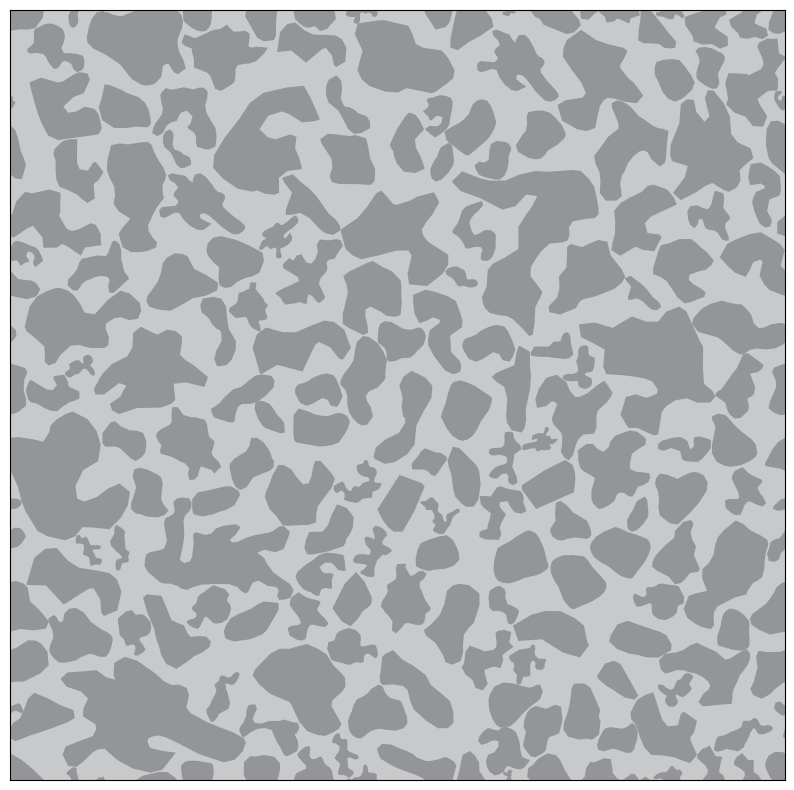

In [21]:
visualize_rve_shaded_single_color(all_splines, grid_bounds=(grid_rows, grid_cols))

# Random Distribution

In [22]:
# Parameters
grid_rows = 500  # Number of rows
grid_cols = 500  # Number of columns
initial_value = 1e9  # A large initial value for the grid points

# Initialize the grid
rve_grid = initialize_rve_grid((grid_rows, grid_cols), initial_value)
#file_path = 'Lobule.xlsx'  # Replace with the correct path
file_path = 'All Shapes Same Area.xlsx'  # Replace with the correct path

scaling_factor = 50 #grid_rows/0.7  # Specify a float value for a fixed factor, or leave as None for random
scaling_bounds = (1, 1)  # Bounds for random scaling factor

# Example usage
rotation_angle = None  # Specify an angle in degrees or leave as None for a random angle

# Example usage
grid_bounds = (grid_rows, grid_cols)  # Replace with actual grid dimensions (grid_rows, grid_columns)

# Use either a manually specified displacement or let it be randomly generated
manual_displacement = None  # Replace with (dx, dy), e.g., (10, 15), for manual displacement

all_splines = []

accumulated_area = 0

space_threshold = 0.4146*50  # Example threshold

while True:

    sheet_number = 6  # Set to a specific integer for a chosen sheet or leave as None for random
    # Read spline coordinates
    
    
    spline_data, chosen_sheet_name = read_spline_coordinates(file_path, sheet_number)
        
    scaled_spline_data = scale_spline(spline_data, scaling_factor, scaling_bounds)
    rotated_spline_data = rotate_spline(scaled_spline_data, rotation_angle)
    displaced_spline_data = displace_spline_uniformly(rotated_spline_data, grid_bounds, manual_displacement)
    
    #densified_spline_data = densify_spline(displaced_spline_data, density=200)  # Densify spline
    
    periodic_spline_data_list = apply_periodic_boundary_disjoint(displaced_spline_data, grid_bounds)
    non_intersecting_splines = check_and_resolve_intersection(periodic_spline_data_list, rve_grid)
    
    spline_area = compute_area_from_final_splines(non_intersecting_splines, density=100)
    #print(spline_area)
    accumulated_area += spline_area
    print("Phase Fraction: " + str(estimate_area(rve_grid)))
    
    rve_grid = update_grid_with_periodic_splines_disjoint(rve_grid, non_intersecting_splines)
    rve_grid = update_grid_distances(rve_grid)
    
    # Append the final splines to the storage
    all_splines.extend(non_intersecting_splines)  # Add each periodic spline to the list
    

    space_threshold = compute_max_distance_from_centroid(spline_data)*scaling_factor
    random_spacious_point = find_random_spacious_point(rve_grid, space_threshold)

    if random_spacious_point:
        print(f"A random spacious grid point above the threshold is at (x, y): {random_spacious_point}")
    else:
        print("No points meet the threshold.")
        break
    
    manual_displacement = random_spacious_point
    #visualize_rve(all_splines, grid_bounds=(grid_rows, grid_cols))

Scaling factor: 50
Rotation angle: 195.276904120587 degrees
Random Displacement (dx, dy): (206.02, 172.05)
No intersection detected. Final spline placement resolved.
Phase Fraction: 0.0
A random spacious grid point above the threshold is at (x, y): (82, 303)
Scaling factor: 50
Rotation angle: 173.16174330952916 degrees
Manual Displacement (dx, dy): (82.00, 303.00)
No intersection detected. Final spline placement resolved.
Phase Fraction: 0.003504
A random spacious grid point above the threshold is at (x, y): (41, 135)
Scaling factor: 50
Rotation angle: 45.44554338040906 degrees
Manual Displacement (dx, dy): (41.00, 135.00)
No intersection detected. Final spline placement resolved.
Phase Fraction: 0.00702
A random spacious grid point above the threshold is at (x, y): (12, 331)
Scaling factor: 50
Rotation angle: 49.95256878568338 degrees
Manual Displacement (dx, dy): (12.00, 331.00)
No intersection detected. Final spline placement resolved.
Phase Fraction: 0.010464
A random spacious grid

Scaling factor: 50
Rotation angle: 156.99959161886522 degrees
Manual Displacement (dx, dy): (450.00, 303.00)
No intersection detected. Final spline placement resolved.
Phase Fraction: 0.108424
A random spacious grid point above the threshold is at (x, y): (141, 46)
Scaling factor: 50
Rotation angle: 194.57714153101855 degrees
Manual Displacement (dx, dy): (141.00, 46.00)
No intersection detected. Final spline placement resolved.
Phase Fraction: 0.111924
A random spacious grid point above the threshold is at (x, y): (33, 495)
Scaling factor: 50
Rotation angle: 302.645658065707 degrees
Manual Displacement (dx, dy): (33.00, 495.00)
No intersection detected. Final spline placement resolved.
Phase Fraction: 0.115424
A random spacious grid point above the threshold is at (x, y): (379, 370)
Scaling factor: 50
Rotation angle: 249.1076362518972 degrees
Manual Displacement (dx, dy): (379.00, 370.00)
No intersection detected. Final spline placement resolved.
Phase Fraction: 0.118908
A random spac

Manual Displacement (dx, dy): (359.00, 339.00)
No intersection detected. Final spline placement resolved.
Phase Fraction: 0.219748
A random spacious grid point above the threshold is at (x, y): (415, 433)
Scaling factor: 50
Rotation angle: 255.95392758076537 degrees
Manual Displacement (dx, dy): (415.00, 433.00)
No intersection detected. Final spline placement resolved.
Phase Fraction: 0.22324
A random spacious grid point above the threshold is at (x, y): (326, 72)
Scaling factor: 50
Rotation angle: 97.80741267277281 degrees
Manual Displacement (dx, dy): (326.00, 72.00)
No intersection detected. Final spline placement resolved.
Phase Fraction: 0.226736
A random spacious grid point above the threshold is at (x, y): (77, 361)
Scaling factor: 50
Rotation angle: 358.78323182851517 degrees
Manual Displacement (dx, dy): (77.00, 361.00)
No intersection detected. Final spline placement resolved.
Phase Fraction: 0.230248
A random spacious grid point above the threshold is at (x, y): (234, 60)
S

A random spacious grid point above the threshold is at (x, y): (273, 148)
Scaling factor: 50
Rotation angle: 141.29778392065163 degrees
Manual Displacement (dx, dy): (273.00, 148.00)
No intersection detected. Final spline placement resolved.
Phase Fraction: 0.33104
A random spacious grid point above the threshold is at (x, y): (165, 332)
Scaling factor: 50
Rotation angle: 10.20156352340582 degrees
Manual Displacement (dx, dy): (165.00, 332.00)
No intersection detected. Final spline placement resolved.
Phase Fraction: 0.334544
A random spacious grid point above the threshold is at (x, y): (396, 213)
Scaling factor: 50
Rotation angle: 354.8723886174754 degrees
Manual Displacement (dx, dy): (396.00, 213.00)
No intersection detected. Final spline placement resolved.
Phase Fraction: 0.338048
A random spacious grid point above the threshold is at (x, y): (206, 108)
Scaling factor: 50
Rotation angle: 88.88976200304162 degrees
Manual Displacement (dx, dy): (206.00, 108.00)
No intersection dete

No intersection detected. Final spline placement resolved.
Phase Fraction: 0.434016
A random spacious grid point above the threshold is at (x, y): (8, 470)
Scaling factor: 50
Rotation angle: 247.72945779176789 degrees
Manual Displacement (dx, dy): (8.00, 470.00)
Intersection detected. Scaling down splines...
Intersection detected. Scaling down splines...
Intersection detected. Scaling down splines...
No intersection detected. Final spline placement resolved.
Phase Fraction: 0.437528
A random spacious grid point above the threshold is at (x, y): (2, 18)
Scaling factor: 50
Rotation angle: 273.3006984207707 degrees
Manual Displacement (dx, dy): (2.00, 18.00)
Intersection detected. Scaling down splines...
No intersection detected. Final spline placement resolved.
Phase Fraction: 0.439388
A random spacious grid point above the threshold is at (x, y): (404, 103)
Scaling factor: 50
Rotation angle: 242.08523614439463 degrees
Manual Displacement (dx, dy): (404.00, 103.00)
No intersection detect

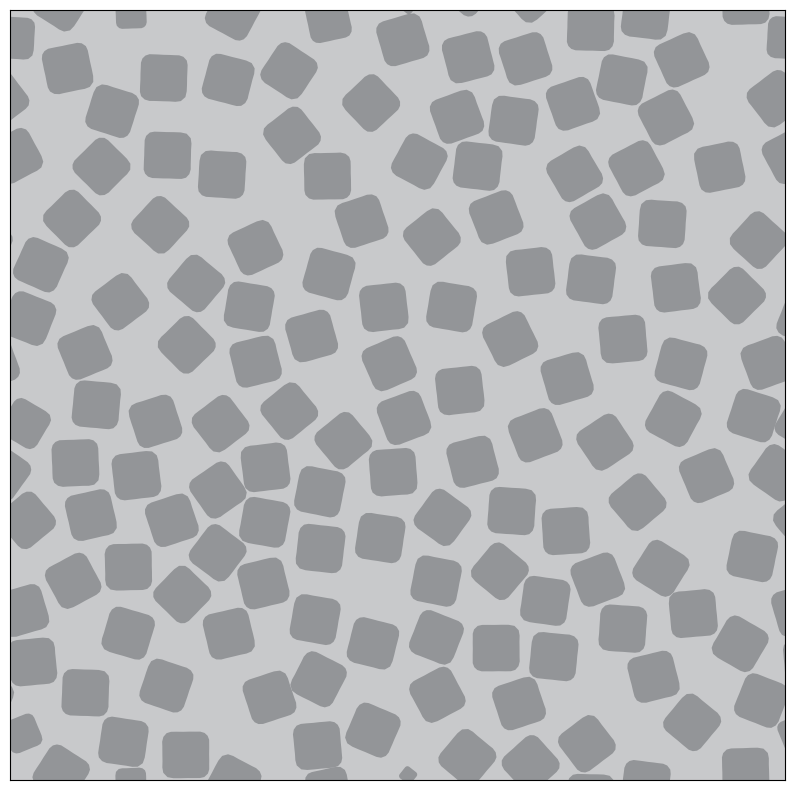

In [23]:
visualize_rve_shaded_single_color(all_splines, grid_bounds=(grid_rows, grid_cols))

In [55]:
export_splines_to_excel(all_splines, "Kidney.xlsx")

Spline data exported successfully to Kidney.xlsx


# Clusted Distribution

In [24]:
# Parameters
grid_rows = 500  # Number of rows
grid_cols = 500  # Number of columns
initial_value = 1e9  # A large initial value for the grid points

# Initialize the grid
rve_grid = initialize_rve_grid((grid_rows, grid_cols), initial_value)
#file_path = 'Lobule.xlsx'  # Replace with the correct path
file_path = 'All Shapes Same Area.xlsx'  # Replace with the correct path

scaling_factor = 50 #grid_rows/0.7  # Specify a float value for a fixed factor, or leave as None for random
scaling_bounds = (1, 1)  # Bounds for random scaling factor

# Example usage
rotation_angle = None  # Specify an angle in degrees or leave as None for a random angle

# Example usage
grid_bounds = (grid_rows, grid_cols)  # Replace with actual grid dimensions (grid_rows, grid_columns)

# Use either a manually specified displacement or let it be randomly generated
manual_displacement = None  # Replace with (dx, dy), e.g., (10, 15), for manual displacement

all_splines = []

accumulated_area = 0

space_threshold = 0.4146*50  # Example threshold
vf_right_now = 0

while vf_right_now < 0.2:

    sheet_number = 5  # Set to a specific integer for a chosen sheet or leave as None for random
    # Read spline coordinates
    
    
    spline_data, chosen_sheet_name = read_spline_coordinates(file_path, sheet_number)
        
    scaled_spline_data = scale_spline(spline_data, scaling_factor, scaling_bounds)
    rotated_spline_data = rotate_spline(scaled_spline_data, rotation_angle)
    displaced_spline_data = displace_spline_uniformly(rotated_spline_data, grid_bounds, manual_displacement)
    
    #densified_spline_data = densify_spline(displaced_spline_data, density=200)  # Densify spline
    
    periodic_spline_data_list = apply_periodic_boundary_disjoint(displaced_spline_data, grid_bounds)
    non_intersecting_splines = check_and_resolve_intersection(periodic_spline_data_list, rve_grid)
    
    spline_area = compute_area_from_final_splines(non_intersecting_splines, density=100)
    print(spline_area)
    accumulated_area += spline_area
    vf_right_now = estimate_area(rve_grid)
    print("Phase Fraction: " + str(vf_right_now))
    
    rve_grid = update_grid_with_periodic_splines_disjoint(rve_grid, non_intersecting_splines)
    rve_grid = update_grid_distances(rve_grid)
    
    # Append the final splines to the storage
    all_splines.extend(non_intersecting_splines)  # Add each periodic spline to the list
    

    space_threshold = compute_max_distance_from_centroid(spline_data)*scaling_factor
    random_spacious_point = find_least_spacious_point(rve_grid, space_threshold)

    if random_spacious_point:
        print(f"A random spacious grid point above the threshold is at (x, y): {random_spacious_point}")
    else:
        print("No points meet the threshold.")
        break
    
    manual_displacement = random_spacious_point
    #visualize_rve(all_splines, grid_bounds=(grid_rows, grid_cols))

Scaling factor: 50
Rotation angle: 165.18506036997627 degrees
Random Displacement (dx, dy): (23.23, 315.30)
No intersection detected. Final spline placement resolved.
884.7238630430656
Phase Fraction: 0.0
A random spacious grid point above the threshold is at (x, y): (45, 345)
Scaling factor: 50
Rotation angle: 318.48101125135497 degrees
Manual Displacement (dx, dy): (45.00, 345.00)
No intersection detected. Final spline placement resolved.
884.7238630431239
Phase Fraction: 0.00348
A random spacious grid point above the threshold is at (x, y): (46, 382)
Scaling factor: 50
Rotation angle: 48.23019141649711 degrees
Manual Displacement (dx, dy): (46.00, 382.00)
No intersection detected. Final spline placement resolved.
884.7238630431239
Phase Fraction: 0.006988
A random spacious grid point above the threshold is at (x, y): (26, 419)
Scaling factor: 50
Rotation angle: 271.6191739349426 degrees
Manual Displacement (dx, dy): (26.00, 419.00)
No intersection detected. Final spline placement re

A random spacious grid point above the threshold is at (x, y): (289, 245)
Scaling factor: 50
Rotation angle: 3.6217313473585744 degrees
Manual Displacement (dx, dy): (289.00, 245.00)
No intersection detected. Final spline placement resolved.
884.723863044288
Phase Fraction: 0.104972
A random spacious grid point above the threshold is at (x, y): (49, 257)
Scaling factor: 50
Rotation angle: 285.33993656605145 degrees
Manual Displacement (dx, dy): (49.00, 257.00)
No intersection detected. Final spline placement resolved.
884.7238630432403
Phase Fraction: 0.108488
A random spacious grid point above the threshold is at (x, y): (333, 253)
Scaling factor: 50
Rotation angle: 332.1603908032882 degrees
Manual Displacement (dx, dy): (333.00, 253.00)
No intersection detected. Final spline placement resolved.
884.723863042891
Phase Fraction: 0.112016
A random spacious grid point above the threshold is at (x, y): (368, 256)
Scaling factor: 50
Rotation angle: 275.1157731623373 degrees
Manual Displace

A random spacious grid point above the threshold is at (x, y): (447, 448)
Scaling factor: 50
Rotation angle: 270.35904689070384 degrees
Manual Displacement (dx, dy): (447.00, 448.00)
No intersection detected. Final spline placement resolved.
884.7238630391657
Phase Fraction: 0.1997
A random spacious grid point above the threshold is at (x, y): (469, 73)
Scaling factor: 50
Rotation angle: 93.42480488430634 degrees
Manual Displacement (dx, dy): (469.00, 73.00)
No intersection detected. Final spline placement resolved.
884.723863042891
Phase Fraction: 0.203184
A random spacious grid point above the threshold is at (x, y): (312, 213)


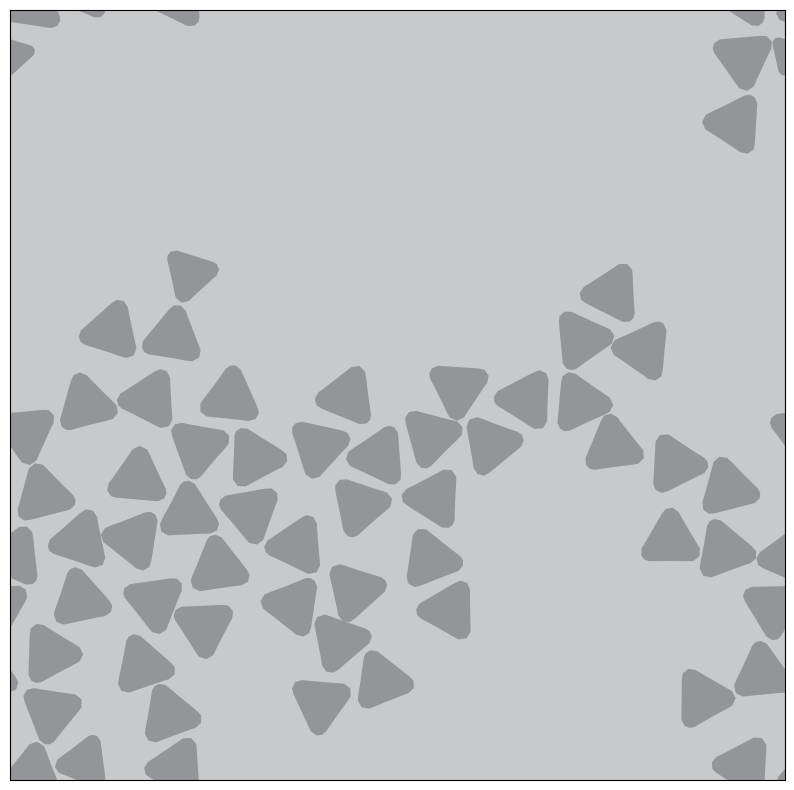

In [25]:
visualize_rve_shaded_single_color(all_splines, grid_bounds=(grid_rows, grid_cols))